# Bottom temperature and salinity comparison to observations (Schmidtko on shelf, WOA in abyss)

In [1]:
import xarray as xr
import numpy as np
import gsw
import glob
import cosima_cookbook as cc

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cmocean.cm as cmocean

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36719,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:37247,Total threads: 4
Dashboard: /proxy/34357/status,Memory: 45.00 GiB
Nanny: tcp://127.0.0.1:37031,


### Control

In [3]:
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
control_session = cc.database.create_session(session_name)

control = '01deg_jra55v13_ryf9091_DSW'

### Perturbations
GPC023 (Basal with Gade, No ICB) `01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb` : Tbasal based on Gade line, calving flux inserted at the surface as runoff

GPC026 (Basal with Gade, Yes ICB with gade) `01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb` : Tbasal based on Gade line and Merino distributed Iceberg Calving Flux on Gade line

GPC029 (Basal No Gade, No ICB) `01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb` : Tbasal equal Tinsitu, calving flux inserted at the surface as runoff

`session_name = '/g/data/ik11/databases/basal_melt_MOM5.db'`

In [4]:
session_name = '/g/data/ik11/databases/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

BasalGade_NoIcb = '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb'  # GPC023
BasalGade_YesIcb = '01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb'  # GPC026
BasalNoGade_NoIcb = '01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb'  # GPC029   

### Functions

First we define a function to read in bottom temperature and salinity from these experiments. 

In [5]:
def select_bottom(ds, depth_array, max_depth):
    bottom_ds = ds.where(depth_array.st_ocean >= max_depth)
    bottom_ds = bottom_ds.sum(dim = 'st_ocean')
    bottom_ds = bottom_ds.load()
    
    return bottom_ds

def read_bottom_data(start_time, end_time, expt, session, lon_slice):
    print(expt)
    
    lat_slice  = slice(-80,-60)
    variables = ['temp', 'salt']   

    temp = cc.querying.getvar(expt,variables[0],session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp = temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(time=slice(start_time,end_time))#.mean('time').load() 

    salt = cc.querying.getvar(expt,variables[1],session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt = salt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(time=slice(start_time,end_time))#.mean('time').load() 

    # convert to absolute salinity
    p = gsw.p_from_z(-temp.st_ocean, temp.yt_ocean)
    SA = gsw.SA_from_SP(salt, p, salt.xt_ocean,  salt.yt_ocean)

    # take mean and load variables
    temp = temp.mean('time').load() 
    SA = SA.mean('time').load() 

    # select bottom
    depth_array = temp * 0 + temp.st_ocean
    max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

    bottom_temp = select_bottom(temp, depth_array, max_depth)
    bottom_salt = select_bottom(SA, depth_array, max_depth)
    

    return bottom_temp, bottom_salt

Now define the plotting fucntions

In [30]:
# read in bathymetry for plotting later
ht = cc.querying.getvar(control, 'ht', control_session, n=-1)

land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

def colorbar_vert(cb, axes, label):
    fs = 10
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax=cbaxes, orientation='vertical', extend = 'both')
    cbar.set_label(label,fontsize=fs+2,labelpad=2)
    cbar.ax.tick_params(labelsize=fs)
    return cbar
    

def colorbar_horz(cb, axes, label):
    fs = 10
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax = cbaxes, orientation = 'horizontal',extend = 'max')
    cbar.set_label(label,fontsize=fs+2,labelpad=2)
    cbar.ax.tick_params(labelsize=fs)
    return cbar
    

def T_S_map_schmitko_comparison():
    labels = ['a)','b)','','','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)']
    expt_labels = ['     OBS', '', '     CONTROL - OBS', r'     $BASAL_{Gade}$ - CONTROL',
                   r'     $BASAL_{Gade}+ICB$ - CONTROL', 
                   r'$BASAL_{NoGade}$']
    
    plt.rcParams['font.size'] = 12
    fig, axes = plt.subplots(5,2, figsize=(18,14),sharex=True, sharey=True, height_ratios=[0.9,0.22,0.9, 0.9,0.9])
    plt.subplots_adjust(wspace=0.05, hspace=0.06)

    for i, ax in enumerate(axes[1,:]):
        fig.delaxes(ax)


    for i, ax in enumerate(axes.flatten()):
        ax.set_ylim(lat_range)
        ax.set_yticks(lat_range_labels)
        ax.set_facecolor('w')
        ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='dimgrey',zorder=2,)
        ax.text(0.02, 0.88, np.repeat(expt_labels, 2)[i], ha='left', fontsize=16, transform=ax.transAxes,
               bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'))
        ax.text(0.02, 0.88, f'{labels[i]}',fontsize=16,fontweight='bold',transform=ax.transAxes, 
               #bbox=dict(facecolor='w', alpha=0.8, edgecolor='dimgrey', boxstyle='round,pad=0.2'), 
               )
        ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2500],colors=['k','grey'],linewidths=0.8)

    for i, ax in enumerate(axes[:,0]):
        ax.set_ylabel('Latitude (\u00b0N)')
         
    axes[0,0].set_title('Bottom Temperature', fontsize=20, pad=12)
    axes[0,1].set_title('Bottom Salinity', fontsize=20, pad=12)
    axes[-1,0].set_xlabel('Longitude (\u00b0E)')
    axes[-1,1].set_xlabel('Longitude (\u00b0E)')
    
    return fig, axes

# define colormaps
from palettable.cmocean.diverging import Balance_9
cmapA = plt.cm.get_cmap(Balance_9.mpl_colormap)
levelsAT = np.arange(-1.5, 1.55, 0.1)
levelsAS = np.arange(-0.2, 0.21, 0.01)

from palettable.cmocean.sequential import Thermal_20
cmapT = plt.cm.get_cmap(Thermal_20.mpl_colormap)
levelsT = np.arange(-2.5, 1.6, 0.1)

from palettable.cmocean.sequential import Haline_20
cmapS = plt.cm.get_cmap(Haline_20.mpl_colormap)
levelsS = np.arange(34.2, 35.025, 0.025)

Create a mask for the continental shelf.  

In [7]:
def shelf_mask_isobath(var,isobath):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load(f'/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_{isobath}m.npz')
    var = var.sel(yt_ocean = slice(-90, -59.03))
    
    shelf_mask = contour_file['contour_masked_above'][26:-1, :]
    yt_ocean = contour_file['yt_ocean'][26:-1]
    xt_ocean = contour_file['xt_ocean']

    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map


# read in dummy variable to creat shelf mask
temp = cc.querying.getvar(control, 'temp', control_session, frequency='1 monthly',start_time='1909-01-01', end_time='1909-02-01')
mask_1000, shelf_map = shelf_mask_isobath(temp.isel(time=0, st_ocean=0), 1000)
mask_1000 = mask_1000.where(np.isnan(mask_1000), 1.)
#mask_1000.plot(figsize=(5,3)); plt.show()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


### Read in model data

Set the region of interest. 

In [8]:
start_time = '1908-01-02'
end_time = '1909-12-30'

region = 'PanAntarctic'
lon_slice = slice(-280, 80)
lat_range = [-79.5, -60]
lat_range_labels = np.arange(-78, -59, 2)
#temp_range = [-2.5, 2]

Read in bottom temperature and salinity from model. 

In [9]:
%%time
# The function `read_bottom_data` will convert the models practical salinity to absolute salinity
# Model temperature is already conservative temperature
bottom_T_ctrl, bottom_S_ctrl = read_bottom_data(start_time, end_time, control, control_session, lon_slice)
bottom_T_Gade_NoIcb, bottom_S_Gade_NoIcb = read_bottom_data(start_time, end_time, BasalGade_NoIcb, basal_melt_session, lon_slice)
bottom_T_Gade_YesIcb, bottom_S_Gade_YesIcb = read_bottom_data(start_time, end_time, BasalGade_YesIcb, basal_melt_session, lon_slice)
# bottom_T_NoGade_NoIcb, bottom_S_NoGade_NoIcb = read_bottom_data(start_time, end_time, BasalNoGade_NoIcb, basal_melt_session, lon_slice)

# replace zeros in control with NaNs
bottom_T_ctrl = bottom_T_ctrl.where(bottom_T_ctrl != 0., np.nan)
bottom_S_ctrl = bottom_S_ctrl.where(bottom_S_ctrl != 0., np.nan)

01deg_jra55v13_ryf9091_DSW


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb
01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb
CPU times: user 5min 2s, sys: 25.7 s, total: 5min 28s
Wall time: 10min 25s


### Read in observations 

Load Schmidtko observations. Units are conservative temperature and absolute salinity, so no conversions necessary. They just need to be interpolated onto the model grid, which we're currently doing in a rather rudimentary manner. 

In [10]:
# this is actually ASBW despite the naming:
filepath = '/g/data/v45/rm2389/Schmidtko_Observations/AASW_Temp_Salt.nc'
Schmidtko_data = xr.open_dataset(filepath)
temp_Schmidtko = Schmidtko_data.CT
salt_Schmidtko = Schmidtko_data.AS

# concat observations onto model grid.
x = temp_Schmidtko.lon.values
x[x> 80] = x[x>80]-360
# replace lon coordinate values with these modified longitude values
temp_Schmidtko['lon'] = x
salt_Schmidtko['lon'] = x
# now concatenate temp and salinity so that it goes from -280 to 80 like access
temp_Schmidtko = xr.concat((temp_Schmidtko[:,321:], temp_Schmidtko[:,:321]), dim='lon')
salt_Schmidtko = xr.concat((salt_Schmidtko[:,321:], salt_Schmidtko[:,:321]), dim='lon')

## To Do ##
## CHANGE TO XESMF CONSERVATIVE REGRIDDING METHOD ##

# interpolate obs onto model grid:
def interp_obs(obs,model_lat,model_lon): 
    obs_new = obs.interp(lat = model_lat, lon = model_lon)
    return obs_new

temp_Schmidtko = interp_obs(temp_Schmidtko,bottom_T_ctrl.yt_ocean,bottom_T_ctrl.xt_ocean)
salt_Schmidtko = interp_obs(salt_Schmidtko,bottom_T_ctrl.yt_ocean,bottom_T_ctrl.xt_ocean)

Load WOA18 observations. These are in situ temperature and (I think) practical salinity, so unit conversions are required.

In [19]:
%%time
woa_dir = '/g/data/e14/hd4873/obs_data/woa/woa18/'
woa_temp = xr.open_dataset(woa_dir+'woa18_decav_t00_01.nc', decode_cf=False).squeeze().sel(lat=slice(None, -59.5))['t_an']
woa_salt = xr.open_dataset(woa_dir+'woa18_decav_s00_01.nc', decode_cf=False).squeeze().sel(lat=slice(None, -59.5))['s_an']
woa_temp

# replace temp and salt land values with np.nan\
woa_temp = woa_temp.where(woa_temp < 1000, np.nan)
woa_salt = woa_salt.where(woa_salt < 1000, np.nan)


# Unit conversions
# Absolute salinity from practical salinity
p = gsw.p_from_z(-woa_salt.depth, woa_salt.lat)
woa_salt = gsw.conversions.SA_from_SP(woa_salt, p, woa_salt.lon, woa_salt.lat)
# Calculate potential temp from in insitu temp using surface reference pressure
p_ref = 0.
woa_temp = gsw.pt_from_t(woa_salt, woa_temp, p, p_ref)
# Calcualte conservative temperature from potential temperature
woa_temp = gsw.CT_from_pt(woa_salt, woa_temp)

# Now select bottom values
depth_array = woa_temp * 0 + woa_temp.depth
max_depth = depth_array.max(dim = 'depth', skipna= True)

def select_bottom(ds, depth_array, max_depth):
    bottom_ds = ds.where(depth_array.depth >= max_depth)
    bottom_ds = bottom_ds.sum(dim = 'depth')
    bottom_ds = bottom_ds.load()
    
    return bottom_ds

bottom_temp_woa = select_bottom(woa_temp, depth_array, max_depth)
bottom_salt_woa = select_bottom(woa_salt, depth_array, max_depth)

# concat observations onto model grid.
x = bottom_temp_woa.lon.values
x[x> 80] = x[x>80]-360

# replace lon coordinate values with these modified longitude values
bottom_temp_woa['lon'] = x
bottom_salt_woa['lon'] = x

# now concatenate temp and salinity so that it goes from -280 to 80 like access
bottom_temp_woa = xr.concat((bottom_temp_woa[:,260:], bottom_temp_woa[:,:260]), dim='lon')
bottom_salt_woa = xr.concat((bottom_salt_woa[:,260:], bottom_salt_woa[:,:260]), dim='lon')

## To Do ##
## CHANGE TO XESMF CONSERVATIVE REGRIDDING METHOD ##
# Now interpolate onto model grid
def interp_obs_woa(obs,model_lat,model_lon): 
    obs_new = obs.interp(lat=model_lat, lon=model_lon)
    return obs_new

temp_WOA18 = interp_obs_woa(bottom_temp_woa,bottom_T_ctrl.yt_ocean,bottom_T_ctrl.xt_ocean).compute()
salt_WOA18 = interp_obs_woa(bottom_salt_woa,bottom_T_ctrl.yt_ocean,bottom_T_ctrl.xt_ocean).compute()

CPU times: user 240 ms, sys: 18.8 ms, total: 258 ms
Wall time: 235 ms


Load WOA13 observations. These are in potential temperature and (I think) practical salinity, so unit conversions are required.

In [12]:
# Create a new WOA database:
db = 'woa13.db'
session_woa = cc.database.create_session(db)

directory_list=['/g/data/hh5/tmp/cosima/woa13/01',]
cc.database.build_index(directory_list, session_woa)

Indexing experiment: 01


0

In [13]:
%%time
expt='01'
lat_slice = slice(-80, -60)
woa13_temp = cc.querying.getvar(expt, 'temp', session_woa).sel(GRID_Y_T = lat_slice).mean('time')#.load()
woa13_salt = cc.querying.getvar(expt, 'salt', session_woa).sel(GRID_Y_T = lat_slice).mean('time')#.load()

# rename coordinates
woa13_temp = woa13_temp.rename({'GRID_Y_T':'yt_ocean', 'GRID_X_T':'xt_ocean', 'ZT':'st_ocean'})
woa13_salt = woa13_salt.rename({'GRID_Y_T':'yt_ocean', 'GRID_X_T':'xt_ocean', 'ZT':'st_ocean'})


# create mask to mask out land in woa fields
mask_woa = temp.isel(time=0).sel(yt_ocean=slice(-80,-60)).copy()
mask_woa = mask_woa.where(np.isnan(mask_woa), 1.)
# mask out land in woa fields
woa13_temp = (woa13_temp * mask_woa.values)
woa13_salt = (woa13_salt * mask_woa.values)


# Unit conversions
# temp is potential temperature 
# salt is unitless (psu?)
# Absolute salinity from practical salinity
p = gsw.p_from_z(-woa13_salt.st_ocean, woa13_salt.yt_ocean)
woa13_salt = gsw.conversions.SA_from_SP(woa13_salt, p, woa13_salt.xt_ocean, woa13_salt.yt_ocean)
# Conservative temp from potential temp
woa13_temp = gsw.CT_from_pt(woa13_salt, woa13_temp)

# Now select bottom values
depth_array = woa13_temp * 0 + woa13_temp.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

def select_bottom(ds, depth_array, max_depth):
    bottom_ds = ds.where(depth_array.st_ocean >= max_depth)
    bottom_ds = bottom_ds.sum(dim = 'st_ocean')
    bottom_ds = bottom_ds.load()
    
    return bottom_ds

temp_WOA13 = select_bottom(woa13_temp, depth_array, max_depth)
salt_WOA13 = select_bottom(woa13_salt, depth_array, max_depth)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_du

CPU times: user 1min 53s, sys: 10.8 s, total: 2min 4s
Wall time: 3min 42s


Now define mask to mask WOA obs only in the abyss north of the 1000 m isobath. 

In [14]:
shelf_map = shelf_map.where(shelf_map == 0., np.nan)
shelf_map = shelf_map.where(np.isnan(shelf_map), 1.)

# Plot figure

WOA13 in abyss, Schmidtko on shelf. 

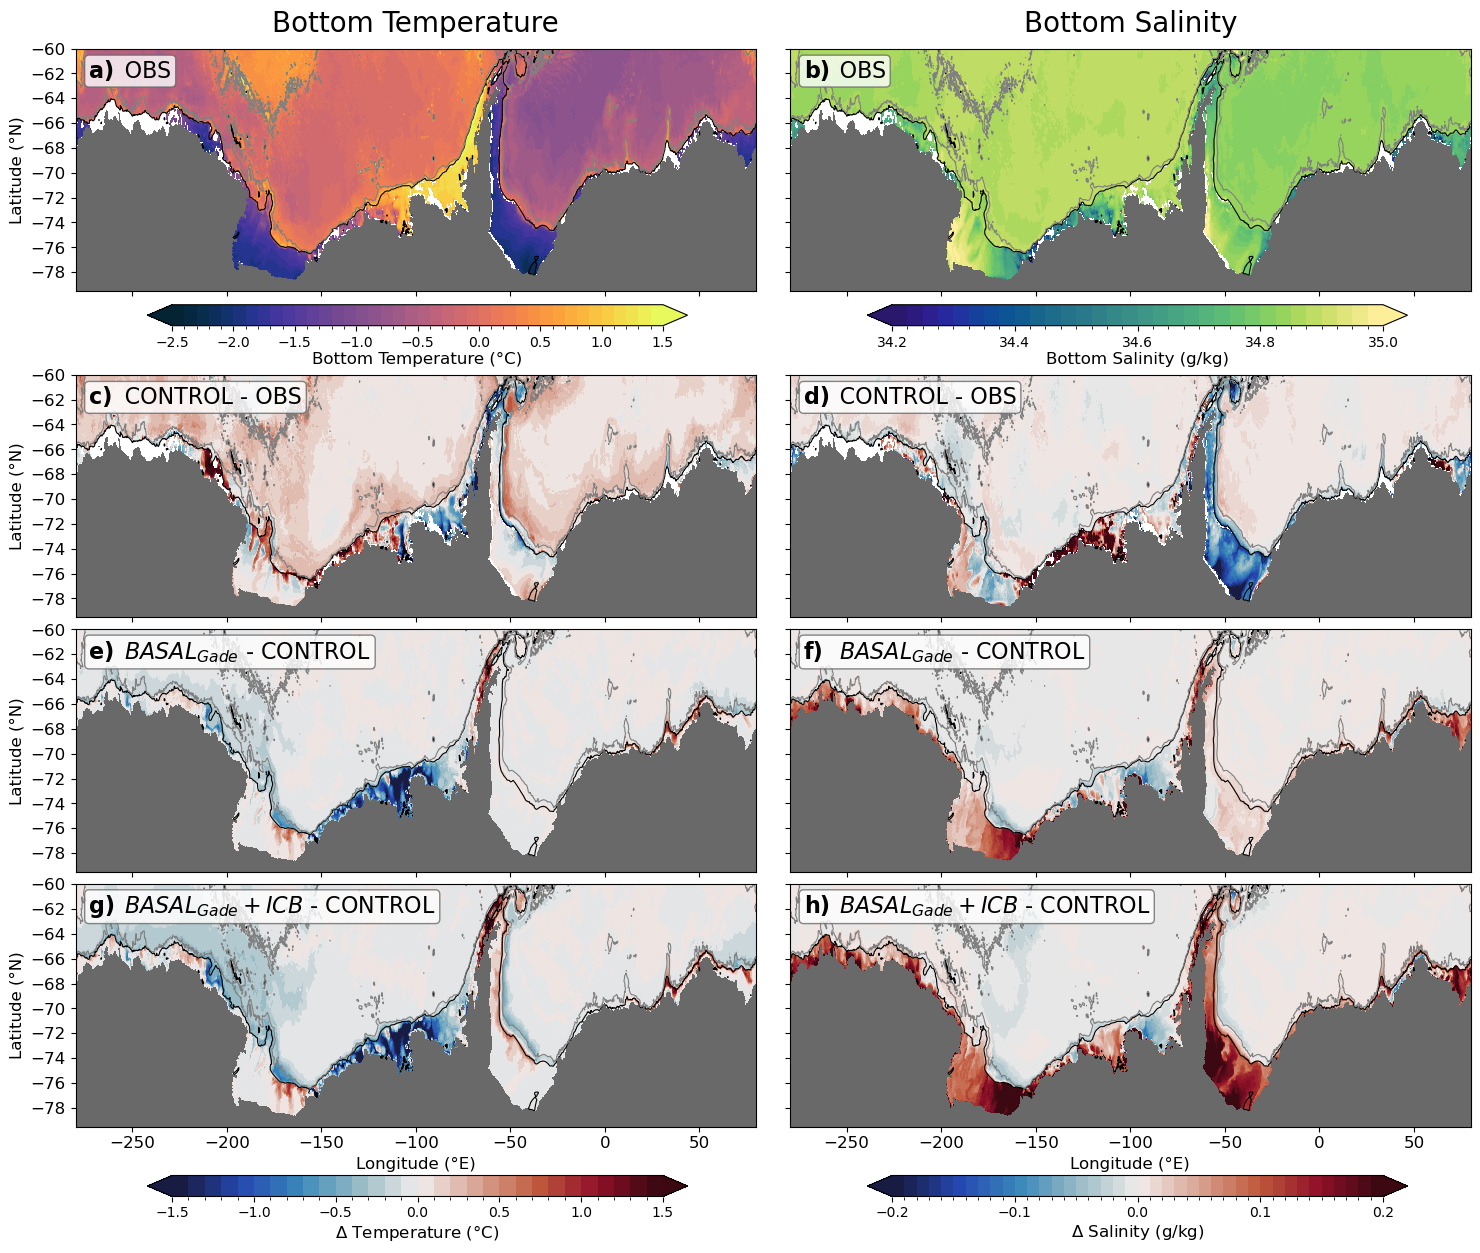

In [36]:
x_map = bottom_T_ctrl.xt_ocean
y_map = bottom_T_ctrl.yt_ocean


fig, axes = T_S_map_schmitko_comparison()

# Plot observations
cbT = axes[0,0].contourf(x_map, y_map, temp_WOA13*shelf_map, cmap=cmapT, 
                   norm=mpl.colors.BoundaryNorm(levelsT,ncolors=cmapT.N, clip=False), 
                   levels=levelsT, extend='both')
cbS = axes[0,1].contourf(x_map, y_map, salt_WOA13*shelf_map, cmap=cmapS, 
                   norm=mpl.colors.BoundaryNorm(levelsS,ncolors=cmapS.N, clip=False), 
                   levels=levelsS, extend='both')
cbT = axes[0,0].contourf(x_map, y_map, temp_Schmidtko, cmap=cmapT, 
                   norm=mpl.colors.BoundaryNorm(levelsT,ncolors=cmapT.N, clip=False), 
                   levels=levelsT, extend='both')
cbS = axes[0,1].contourf(x_map, y_map, salt_Schmidtko, cmap=cmapS, 
                   norm=mpl.colors.BoundaryNorm(levelsS,ncolors=cmapS.N, clip=False), 
                   levels=levelsS, extend='both')
# Add OBS colorbars
cbar = colorbar_horz(cbT, [0.165, 0.682, 0.3, 0.015], 'Bottom Temperature (\u00b0C)')
cbar.ax.set_xticks(np.arange(-2.5, 1.6, 0.5))
cbar = colorbar_horz(cbS, [0.565, 0.682, 0.3, 0.015], 'Bottom Salinity (g/kg)')
cbar.ax.set_xticks(np.arange(34.2, 35.05, 0.2))

# Plot CONTROL biases from OBS
axes[2,0].contourf(x_map, y_map, bottom_T_ctrl - temp_WOA13*shelf_map, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAT,ncolors=cmapA.N, clip=False), 
                   levels=levelsAT, extend='both')
axes[2,1].contourf(x_map, y_map, bottom_S_ctrl - salt_WOA13*shelf_map, cmap=cmapA, 
                         norm=mpl.colors.BoundaryNorm(levelsAS,ncolors=cmapA.N, clip=False), 
                         levels=levelsAS, extend='both')
axes[2,0].contourf(x_map, y_map, bottom_T_ctrl - temp_Schmidtko, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAT,ncolors=cmapA.N, clip=False), 
                   levels=levelsAT, extend='both')
axes[2,1].contourf(x_map, y_map, bottom_S_ctrl - salt_Schmidtko, cmap=cmapA, 
                         norm=mpl.colors.BoundaryNorm(levelsAS,ncolors=cmapA.N, clip=False), 
                         levels=levelsAS, extend='both')

# Add bottom temperature anomalies from CONTROL
cbAT = axes[3,0].contourf(x_map, y_map, bottom_T_Gade_NoIcb - bottom_T_ctrl, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAT,ncolors=cmapA.N, clip=False), 
                   levels=levelsAT, extend='both')
axes[4,0].contourf(x_map, y_map, bottom_T_Gade_YesIcb - bottom_T_ctrl, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAT,ncolors=cmapA.N, clip=False), 
                   levels=levelsAT, extend='both')

# Add bottom salinity anomalies
cbAS = axes[3,1].contourf(x_map, y_map, bottom_S_Gade_NoIcb - bottom_S_ctrl, cmap=cmapA, 
                         norm=mpl.colors.BoundaryNorm(levelsAS,ncolors=cmapA.N, clip=False), 
                         levels=levelsAS, extend='both')
axes[4,1].contourf(x_map, y_map, bottom_S_Gade_YesIcb - bottom_S_ctrl, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAS,ncolors=cmapA.N, clip=False), 
                   levels=levelsAS, extend='both')

cbar = colorbar_horz(cbAT, [0.165, 0.06, 0.3, 0.015], '$\Delta$ Temperature (\u00b0C)')
cbar.ax.set_xticks(np.arange(-1.5, 1.6, 0.5))
cbar = colorbar_horz(cbAS, [0.565, 0.06, 0.3, 0.015], '$\Delta$ Salinity (g/kg)')
cbar.ax.set_xticks(np.arange(-0.2, 0.21, 0.1))

fig.savefig('Figure04_T-S_obs_bottom_comparison_woa13.jpg', bbox_inches='tight', dpi=300)

plt.show()

WOA18 in abyss, Schmidtko on shelf. 

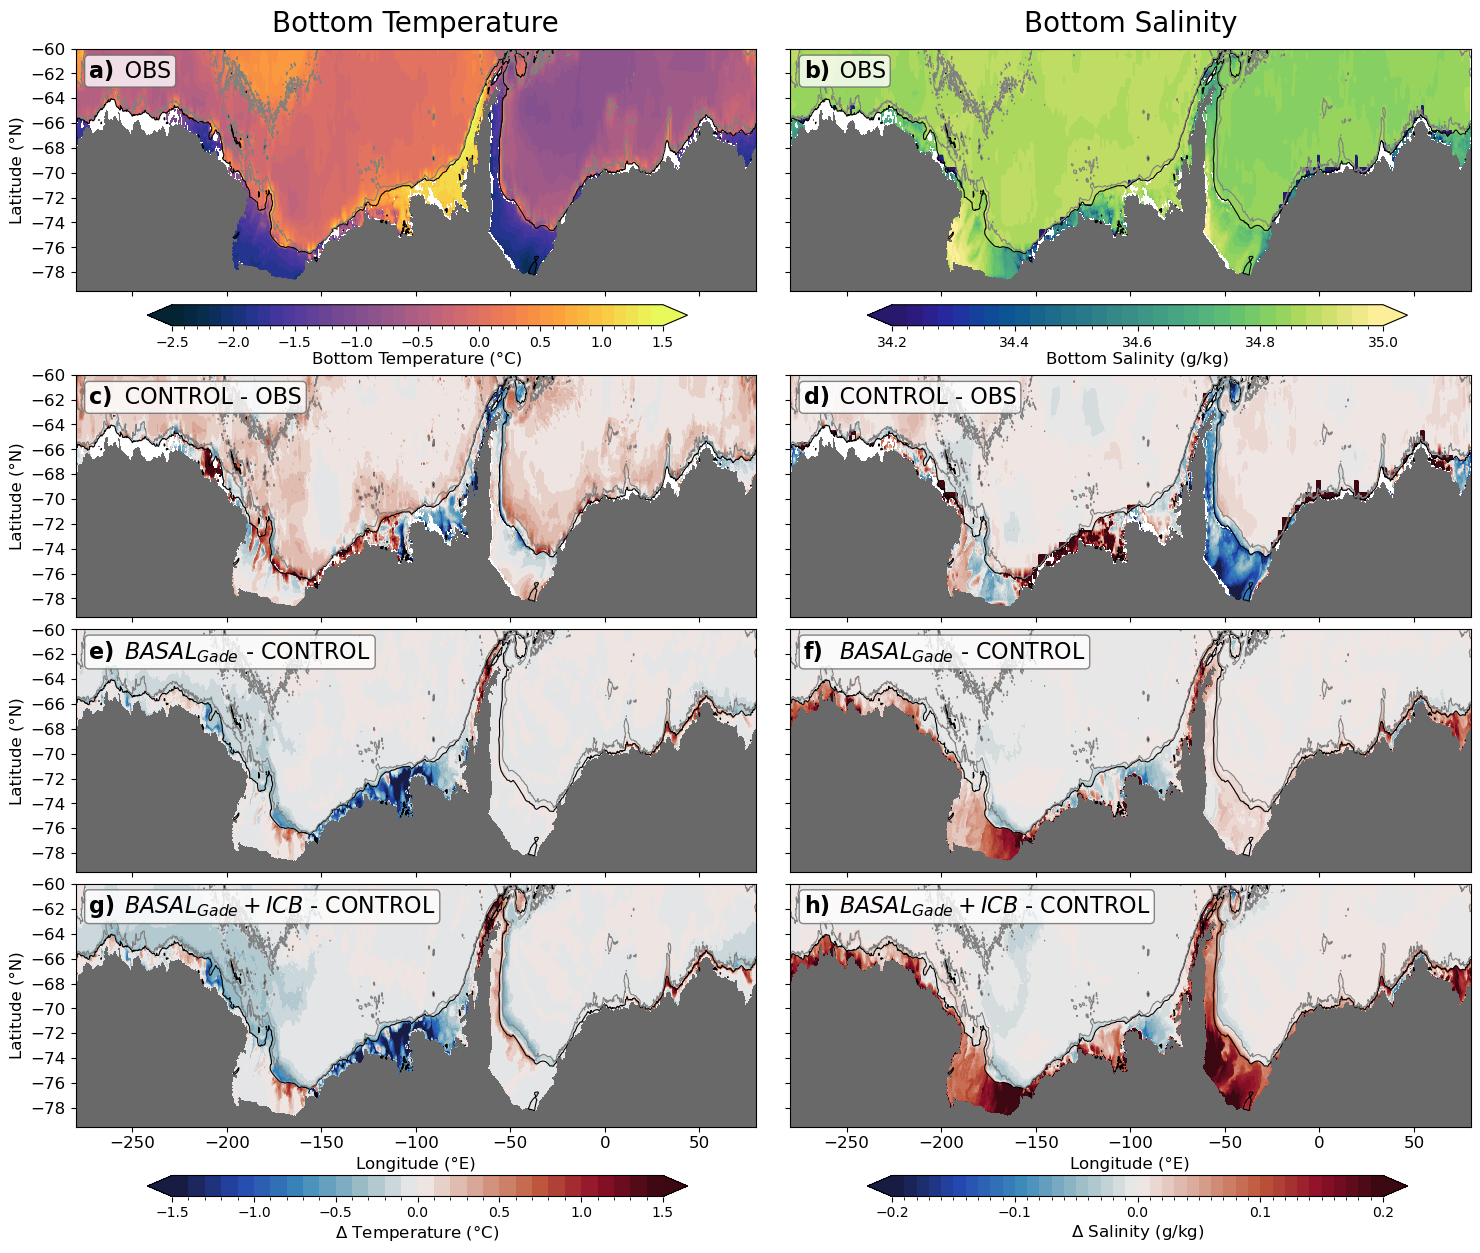

In [37]:
x_map = bottom_T_ctrl.xt_ocean
y_map = bottom_T_ctrl.yt_ocean


fig, axes = T_S_map_schmitko_comparison()

# Plot observations
cbT = axes[0,0].contourf(x_map, y_map, temp_WOA18*shelf_map, cmap=cmapT, 
                   norm=mpl.colors.BoundaryNorm(levelsT,ncolors=cmapT.N, clip=False), 
                   levels=levelsT, extend='both')
cbS = axes[0,1].contourf(x_map, y_map, salt_WOA18*shelf_map, cmap=cmapS, 
                   norm=mpl.colors.BoundaryNorm(levelsS,ncolors=cmapS.N, clip=False), 
                   levels=levelsS, extend='both')
cbT = axes[0,0].contourf(x_map, y_map, temp_Schmidtko, cmap=cmapT, 
                   norm=mpl.colors.BoundaryNorm(levelsT,ncolors=cmapT.N, clip=False), 
                   levels=levelsT, extend='both')
cbS = axes[0,1].contourf(x_map, y_map, salt_Schmidtko, cmap=cmapS, 
                   norm=mpl.colors.BoundaryNorm(levelsS,ncolors=cmapS.N, clip=False), 
                   levels=levelsS, extend='both')
# Add OBS colorbars
cbar = colorbar_horz(cbT, [0.165, 0.682, 0.3, 0.015], 'Bottom Temperature (\u00b0C)')
cbar.ax.set_xticks(np.arange(-2.5, 1.6, 0.5))
cbar = colorbar_horz(cbS, [0.565, 0.682, 0.3, 0.015], 'Bottom Salinity (g/kg)')
cbar.ax.set_xticks(np.arange(34.2, 35.05, 0.2))

# Plot CONTROL biases from OBS
axes[2,0].contourf(x_map, y_map, bottom_T_ctrl - temp_WOA18*shelf_map, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAT,ncolors=cmapA.N, clip=False), 
                   levels=levelsAT, extend='both')
axes[2,1].contourf(x_map, y_map, bottom_S_ctrl - salt_WOA18*shelf_map, cmap=cmapA, 
                         norm=mpl.colors.BoundaryNorm(levelsAS,ncolors=cmapA.N, clip=False), 
                         levels=levelsAS, extend='both')
axes[2,0].contourf(x_map, y_map, bottom_T_ctrl - temp_Schmidtko, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAT,ncolors=cmapA.N, clip=False), 
                   levels=levelsAT, extend='both')
axes[2,1].contourf(x_map, y_map, bottom_S_ctrl - salt_Schmidtko, cmap=cmapA, 
                         norm=mpl.colors.BoundaryNorm(levelsAS,ncolors=cmapA.N, clip=False), 
                         levels=levelsAS, extend='both')

# Add bottom temperature anomalies from CONTROL
cbAT = axes[3,0].contourf(x_map, y_map, bottom_T_Gade_NoIcb - bottom_T_ctrl, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAT,ncolors=cmapA.N, clip=False), 
                   levels=levelsAT, extend='both')
axes[4,0].contourf(x_map, y_map, bottom_T_Gade_YesIcb - bottom_T_ctrl, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAT,ncolors=cmapA.N, clip=False), 
                   levels=levelsAT, extend='both')

# Add bottom salinity anomalies
cbAS = axes[3,1].contourf(x_map, y_map, bottom_S_Gade_NoIcb - bottom_S_ctrl, cmap=cmapA, 
                         norm=mpl.colors.BoundaryNorm(levelsAS,ncolors=cmapA.N, clip=False), 
                         levels=levelsAS, extend='both')
axes[4,1].contourf(x_map, y_map, bottom_S_Gade_YesIcb - bottom_S_ctrl, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAS,ncolors=cmapA.N, clip=False), 
                   levels=levelsAS, extend='both')

cbar = colorbar_horz(cbAT, [0.165, 0.06, 0.3, 0.015], '$\Delta$ Temperature (\u00b0C)')
cbar.ax.set_xticks(np.arange(-1.5, 1.6, 0.5))
cbar = colorbar_horz(cbAS, [0.565, 0.06, 0.3, 0.015], '$\Delta$ Salinity (g/kg)')
cbar.ax.set_xticks(np.arange(-0.2, 0.21, 0.1))

fig.savefig('Figure04_T-S_obs_bottom_comparison_woa18.jpg', bbox_inches='tight', dpi=300)

plt.show()

### Now compare everything to just Schmidtko, not to control. 

Ignore the `- CONTROL` labels. These are set in the figure function. 

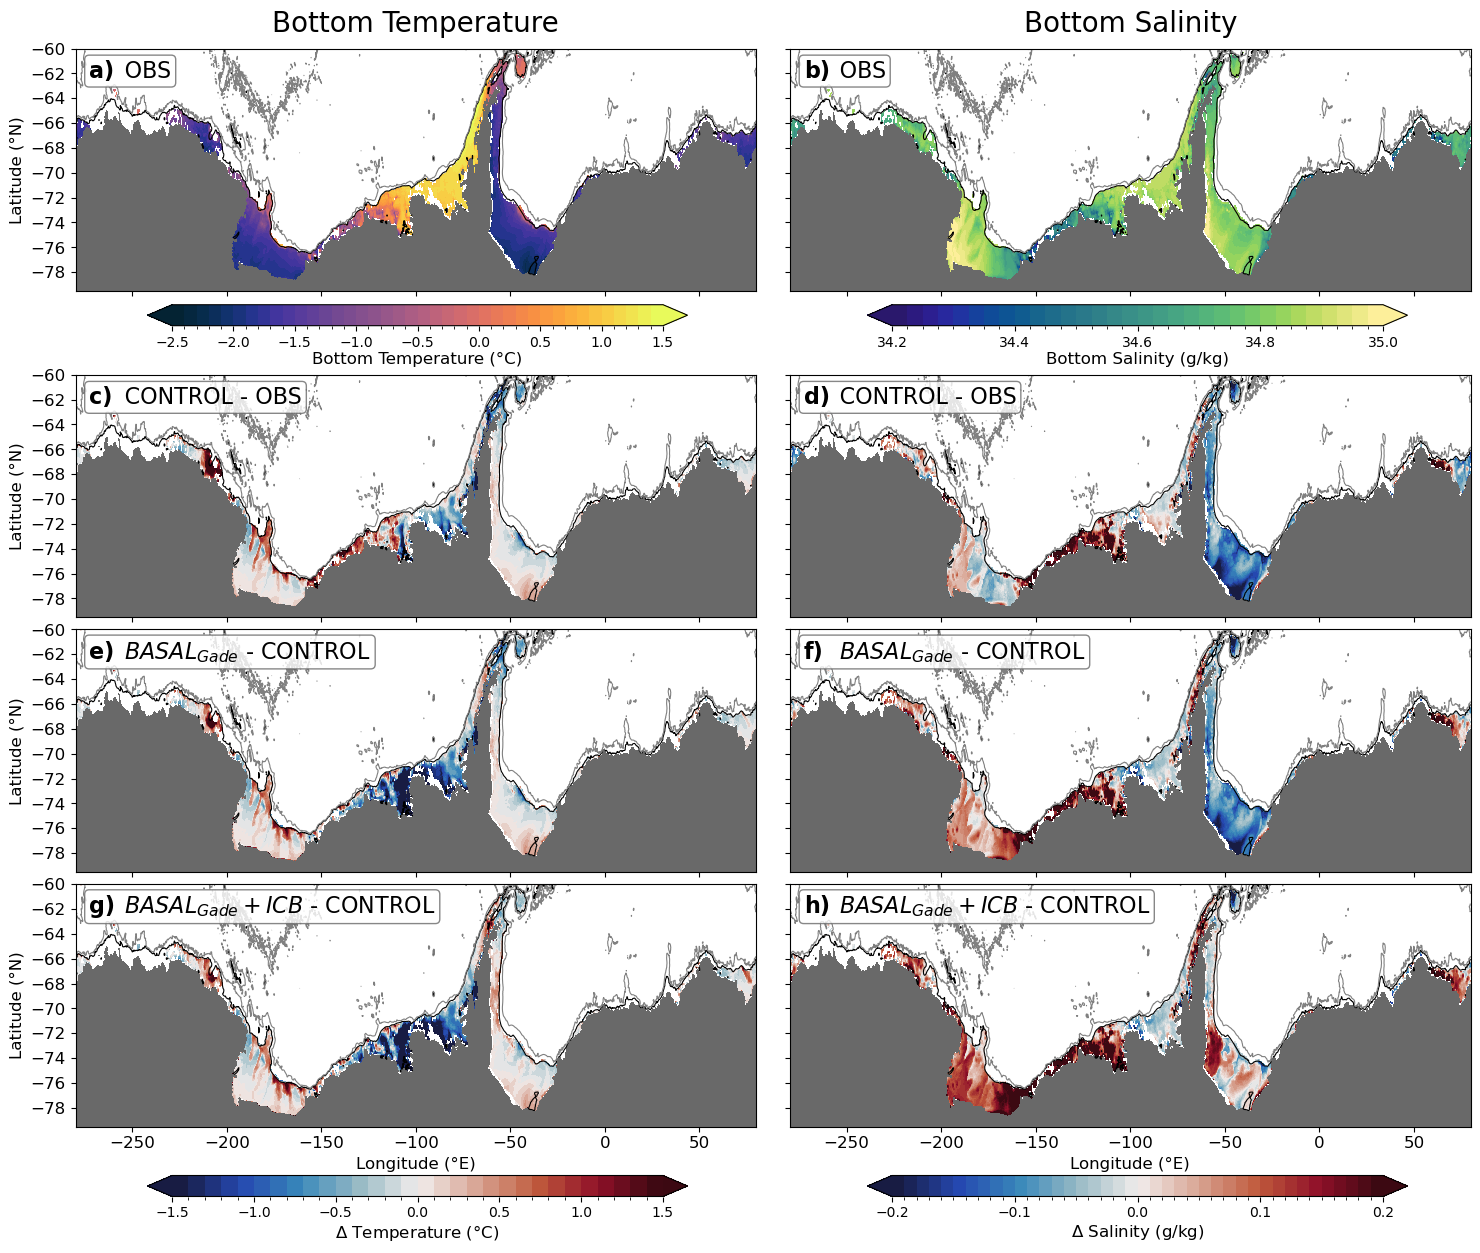

In [38]:
x_map = bottom_T_ctrl.xt_ocean
y_map = bottom_T_ctrl.yt_ocean


fig, axes = T_S_map_schmitko_comparison()

# Plot observations
cbT = axes[0,0].contourf(x_map, y_map, temp_Schmidtko, cmap=cmapT, 
                   norm=mpl.colors.BoundaryNorm(levelsT,ncolors=cmapT.N, clip=False), 
                   levels=levelsT, extend='both')
cbS = axes[0,1].contourf(x_map, y_map, salt_Schmidtko, cmap=cmapS, 
                   norm=mpl.colors.BoundaryNorm(levelsS,ncolors=cmapS.N, clip=False), 
                   levels=levelsS, extend='both')
# Add OBS colorbars
cbar = colorbar_horz(cbT, [0.165, 0.682, 0.3, 0.015], 'Bottom Temperature (\u00b0C)')
cbar.ax.set_xticks(np.arange(-2.5, 1.6, 0.5))
cbar = colorbar_horz(cbS, [0.565, 0.682, 0.3, 0.015], 'Bottom Salinity (g/kg)')
cbar.ax.set_xticks(np.arange(34.2, 35.05, 0.2))

# Plot CONTROL biases from OBS
axes[2,0].contourf(x_map, y_map, bottom_T_ctrl - temp_Schmidtko, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAT,ncolors=cmapA.N, clip=False), 
                   levels=levelsAT, extend='both')
axes[2,1].contourf(x_map, y_map, bottom_S_ctrl - salt_Schmidtko, cmap=cmapA, 
                         norm=mpl.colors.BoundaryNorm(levelsAS,ncolors=cmapA.N, clip=False), 
                         levels=levelsAS, extend='both')

# Add bottom temperature anomalies from CONTROL
cbAT = axes[3,0].contourf(x_map, y_map, bottom_T_Gade_NoIcb - temp_Schmidtko, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAT,ncolors=cmapA.N, clip=False), 
                   levels=levelsAT, extend='both')
axes[4,0].contourf(x_map, y_map, bottom_T_Gade_YesIcb - temp_Schmidtko, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAT,ncolors=cmapA.N, clip=False), 
                   levels=levelsAT, extend='both')

# Add bottom salinity anomalies
cbAS = axes[3,1].contourf(x_map, y_map, bottom_S_Gade_NoIcb - salt_Schmidtko, cmap=cmapA, 
                         norm=mpl.colors.BoundaryNorm(levelsAS,ncolors=cmapA.N, clip=False), 
                         levels=levelsAS, extend='both')
axes[4,1].contourf(x_map, y_map, bottom_S_Gade_YesIcb - salt_Schmidtko, cmap=cmapA, 
                   norm=mpl.colors.BoundaryNorm(levelsAS,ncolors=cmapA.N, clip=False), 
                   levels=levelsAS, extend='both')

cbar = colorbar_horz(cbAT, [0.165, 0.06, 0.3, 0.015], '$\Delta$ Temperature (\u00b0C)')
cbar.ax.set_xticks(np.arange(-1.5, 1.6, 0.5))
cbar = colorbar_horz(cbAS, [0.565, 0.06, 0.3, 0.015], '$\Delta$ Salinity (g/kg)')
cbar.ax.set_xticks(np.arange(-0.2, 0.21, 0.1))


plt.show()